In [1]:
import sys
import os
from tqdm import tqdm

import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
print("PyTorch version: ", torch.__version__)
print("GPU Detected:" ,torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

#defining a shortcut function for later:
# import os
# using_GPU = os.path.exists('/opt/bin/nvidia-smi')

using_GPU = torch.cuda.is_available()


PyTorch version:  1.9.0+cu102
GPU Detected: True
GPU Device Name: NVIDIA GeForce MX150


# Google Colab setup
Run this only if you're training on colab. 
Make sure you have added the shared drive as a shortcut to the **root** of your google drive.

If you're training your model offline and this cell throws `SyntaxError`, just ignore it.

In [3]:
# currentlyRunningOnColab = 'google.colab' in sys.modules
# if currentlyRunningOnColab:
#   # Mount your own Google Drive
#   from google.colab import drive
#   drive.mount('/content/drive', force_remount=True)
#   print("Mounted Google drive of current user")

#   %cd /content
#   print("Changed current directory to /content")

#   # Mount github repository
#   !git clone https://github.com/beazt123/AI-Project2021SUTD.git
#   print("\nCloned repo onto current instance of machine")
  
#   %cd AI-Project2021SUTD
#   print("\nCurrently operating in the root directory of the Git repository")

#   # dataFolderName = "aiproject"
#   GITHUB_REPO_NAME = "AI-Project2021SUTD"
#   codePath = GITHUB_REPO_NAME
#   # /content/drive/.shortcut-targets-by-id/1OU-Ua5tGwc7PDL_nf0s1CPKoIQduRW5q/50.021 AI Project

# Set up the path where the data is stored
Currently, this is set to an online directory. Change it if you're training it offline.

In [4]:
# # Change this variable if u wanna train offline
# dataFolderPath = os.path.join("/content",
#                               "drive", 
#                               ".shortcut-targets-by-id", 
#                               "19icV-F9BFrur0fxo4XvAZ82qIhipVrb-",
#                               "aiProjectData50021")
# # /content/drive/.shortcut-targets-by-id/19icV-F9BFrur0fxo4XvAZ82qIhipVrb-/aiProjectData50021

In [5]:
dataFolderPath = os.path.join("data")

# Preparing the data
I'm assuming that the data is stored in the exact same structure as the one on our shared drive because the code in this section is written like that

```
dataFolder
  |--COVID DATASET 1
  |         |--someCSV.csv
  |         |--anotherCSV.csv
  |--COVID DATASET 2
  |         |--someCSV2.csv
  |         |--anotherCSV2.csv
  |--COVID DATASET 3
            |--someCSV3.csv
            |--anotherCSV3.csv
```

## Split into Training and Test sets

In [6]:
trainingPercentage = 0.7
testPercentage = 0.3

In [7]:
folders = ["COVID DATASET 1","COVID DATASET 2"]#, "COVID DATASET 3"]
csvLists = [glob.glob(f"{dataFolderPath}/{folder}/*.csv") for folder in folders]

In [8]:
overallTrain = []
overallTest = []
for csvList in csvLists:  
  train, test = train_test_split(csvList,
                                test_size=testPercentage,
                                train_size=trainingPercentage)
  overallTrain.extend(train)
  overallTest.extend(test)

## Define and fine tune the pre-process function
Our dataset contains many columns we don't need

In [9]:
def preProcessDataFrame(df: pd.DataFrame) -> pd.DataFrame:
  """
  Takes in a dataframe and returns another dataframe that contains only the data we want.
  Might wanna normalise the data as well
  Maybe fill the nulls with zeros or other appropriate values.
  """
  df_cp = df.copy()

  # to commnet out
  # cols = [
  #         'tweet id',
  #         "followers",
  #         "friends",
  #         "retweets",
  #         "favorites",
  #         "date.hour",
  #         "date.min",
  #         "date.sec",
  #         "time.date"
  #         ]
  # df_cp[cols] = df_cp[cols].apply(pd.to_numeric, errors='coerce', axis=1, downcast="integer")
  
  df_cp.dropna(axis=0,
               how='any', 
               subset=["username", "tweet id"], 
               inplace=True)
  
  # df_cp = df_cp
  df_cp = df_cp[["followers",
                "friends",
                "retweets",
                "positive_sentiment",
                "negative_sentiment",
                # "date.hour",
                "no_hashtag",
                "no_mentions"]].fillna(0).astype(int)
  return df_cp


# sampleDf = pd.read_csv(overallTrain[0])
sampleDf = pd.read_csv(f"{dataFolderPath}/COVID DATASET 1/COVID11.csv")
# print(sampleDf.head())
print(sampleDf.info())
# [print(x) for x in sampleDf.columns] # show list of columns in sampleDf
print("\n====[AFTER PRE-PROCESSING]====\n")
# print(preProcessDataFrame(sampleDf.head()))
pp = preProcessDataFrame(sampleDf)
print(pp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          10000 non-null  int64  
 1   tweet id            10000 non-null  object 
 2   username            9991 non-null   object 
 3   timestamp           9991 non-null   object 
 4   followers           9991 non-null   float64
 5   friends             9991 non-null   float64
 6   retweets            9991 non-null   float64
 7   favorites           9991 non-null   float64
 8   entities            9991 non-null   object 
 9   sentiment           9991 non-null   object 
 10  mentions            9970 non-null   object 
 11  hashtags            9989 non-null   object 
 12  urls                9982 non-null   object 
 13  n                   4796 non-null   float64
 14  positive_sentiment  9991 non-null   float64
 15  negative_sentiment  9991 non-null   float64
 16  date.

In [10]:
class TwitterDataset(Dataset):
  def __init__(self, filenames, preProcessFunc = None):
    # `filenames` is a list of strings the contains all file names.
    # `batch_size` is the determines the number of files that we want to read in a chunk.
        self.filenames = filenames
        self.preProcess = preProcessFunc
  def __len__(self):
        return len(self.filenames)
  def __getitem__(self, idx): #idx means index of the chunk.
    # In this method, we do all the preprocessing.
    # First read data from files in a chunk. Preprocess it. Extract labels. Then return data and labels.
        csvFile = self.filenames[idx]
        df = pd.read_csv(csvFile)
        if self.preProcess:
          df = self.preProcess(df)

        x_arr = torch.Tensor(df.drop(columns=['retweets']).to_numpy().astype(float))
        y = torch.Tensor(df["retweets"].to_numpy().astype(float))
        X = torch.squeeze( x_arr )
        if idx == self.__len__():  
          raise IndexError
        return X, y
  def sample_df(self, idx = 0):
    return self[idx]

In [11]:
train_loader = DataLoader(dataset = TwitterDataset(overallTrain, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)

# Build the network
Make sure this network takes in whatever input you give it and outputs a number. Alternative, if this is an immediate model, like the zero/more than zero retweets classifier, than train it and save the parameters externally. Then train the regressor in another copy of this script.

In [12]:
class myNeuralNetwork(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork, self).__init__()

    self.fc1 = nn.Linear(input_size, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(2048)
    self.batchnorm2 = nn.BatchNorm1d(512)
    self.batchnorm3 = nn.BatchNorm1d(128)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x

class myNeuralNetwork2(nn.Module):
  def __init__(self, input_size):
    super(myNeuralNetwork2, self).__init__()

    a = 256
    b = 16

    self.fc1 = nn.Linear(input_size, a)
    self.fc2 = nn.Linear(a, b)
    self.fc3 = nn.Linear(b, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(a)
    self.batchnorm2 = nn.BatchNorm1d(b)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    # x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc3(x))

    return x
  

# Train the network
## Training parameters
Choice of optimiser and loss and training params are entirely up to you

In [13]:
numEpochs = 100
lr_rate = 1e-4

input_size = 6

b_size = 1028

# model = myNeuralNetwork(input_size)
model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate, momentum=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [14]:
if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

Model on GPU?:
True


## Training for-loop

In [15]:
loss_lst = []

for i in tqdm(range(numEpochs)):
  for X_a, y_a in train_loader:
    
    X_a = torch.squeeze(X_a)
    y_a = y_a.T

    l = int(len(X_a)/b_size)

    for m in range(l):
      a = m*b_size
      b = (m+1)*b_size-1

      X = X_a[a:b]
      y = y_a[a:b]

      if using_GPU:
        X = X.cuda()
        y = y.cuda()

      y_hat = model(X)

      optimizer.zero_grad() 
      y_hat = model(X)
      y_log = torch.log(y+1)
      loss = loss_function(y_hat, y_log) #calculate the loss
      loss.backward() #backprop
      optimizer.step() #does the update

  loss_lst.append(loss.cpu().data.numpy())
  if i % 1 == 0:
    print ("Epoch: {0}, Loss: {1}, ".format(i, loss.cpu().data.numpy()))


  1%|          | 1/100 [01:55<3:10:09, 115.25s/it]

Epoch: 0, Loss: 4.309839725494385, 


  2%|▏         | 2/100 [04:31<3:47:56, 139.56s/it]

Epoch: 1, Loss: 3.944561719894409, 


  3%|▎         | 3/100 [05:54<3:03:22, 113.42s/it]

Epoch: 2, Loss: 4.262363433837891, 


  4%|▍         | 4/100 [07:09<2:37:15, 98.28s/it] 

Epoch: 3, Loss: 4.940329074859619, 


  5%|▌         | 5/100 [08:59<2:42:11, 102.44s/it]

Epoch: 4, Loss: 4.412867546081543, 


  6%|▌         | 6/100 [10:29<2:34:01, 98.31s/it] 

Epoch: 5, Loss: 4.569885730743408, 


  7%|▋         | 7/100 [12:12<2:34:41, 99.80s/it]

Epoch: 6, Loss: 3.019040107727051, 


  8%|▊         | 8/100 [13:30<2:22:20, 92.84s/it]

Epoch: 7, Loss: 2.8104472160339355, 


  9%|▉         | 9/100 [14:57<2:18:07, 91.07s/it]

Epoch: 8, Loss: 3.3038580417633057, 


 10%|█         | 10/100 [16:24<2:14:58, 89.98s/it]

Epoch: 9, Loss: 2.4140877723693848, 


 11%|█         | 11/100 [17:35<2:04:53, 84.20s/it]

Epoch: 10, Loss: 3.0219948291778564, 


 12%|█▏        | 12/100 [18:51<1:59:47, 81.67s/it]

Epoch: 11, Loss: 2.73101806640625, 


 13%|█▎        | 13/100 [20:17<2:00:00, 82.77s/it]

Epoch: 12, Loss: 2.287541151046753, 


 14%|█▍        | 14/100 [21:28<1:53:39, 79.30s/it]

Epoch: 13, Loss: 2.6087658405303955, 


 15%|█▌        | 15/100 [22:58<1:56:47, 82.44s/it]

Epoch: 14, Loss: 2.6399123668670654, 


 16%|█▌        | 16/100 [24:16<1:53:38, 81.17s/it]

Epoch: 15, Loss: 2.613487482070923, 


 17%|█▋        | 17/100 [25:30<1:49:14, 78.97s/it]

Epoch: 16, Loss: 2.40697979927063, 


 18%|█▊        | 18/100 [26:46<1:46:46, 78.13s/it]

Epoch: 17, Loss: 2.202956438064575, 


 19%|█▉        | 19/100 [27:56<1:42:07, 75.65s/it]

Epoch: 18, Loss: 2.13983154296875, 


 20%|██        | 20/100 [29:03<1:37:25, 73.06s/it]

Epoch: 19, Loss: 2.643399715423584, 


 21%|██        | 21/100 [30:09<1:33:20, 70.90s/it]

Epoch: 20, Loss: 2.1883702278137207, 


 22%|██▏       | 22/100 [31:14<1:30:09, 69.35s/it]

Epoch: 21, Loss: 2.709721326828003, 


 23%|██▎       | 23/100 [32:22<1:28:16, 68.79s/it]

Epoch: 22, Loss: 2.103571653366089, 


 24%|██▍       | 24/100 [33:31<1:27:14, 68.88s/it]

Epoch: 23, Loss: 2.0311954021453857, 


 25%|██▌       | 25/100 [34:43<1:27:28, 69.98s/it]

Epoch: 24, Loss: 2.5319104194641113, 


 26%|██▌       | 26/100 [35:52<1:25:43, 69.51s/it]

Epoch: 25, Loss: 2.3524842262268066, 


 27%|██▋       | 27/100 [37:00<1:24:06, 69.13s/it]

Epoch: 26, Loss: 2.389331817626953, 


 28%|██▊       | 28/100 [38:09<1:22:45, 68.96s/it]

Epoch: 27, Loss: 2.5142083168029785, 


 29%|██▉       | 29/100 [39:16<1:21:08, 68.57s/it]

Epoch: 28, Loss: 2.3432881832122803, 


 30%|███       | 30/100 [40:29<1:21:17, 69.69s/it]

Epoch: 29, Loss: 2.7847518920898438, 


 31%|███       | 31/100 [41:44<1:22:15, 71.53s/it]

Epoch: 30, Loss: 2.289015293121338, 


 32%|███▏      | 32/100 [43:06<1:24:34, 74.63s/it]

Epoch: 31, Loss: 2.1533708572387695, 


 33%|███▎      | 33/100 [45:17<1:42:10, 91.50s/it]

Epoch: 32, Loss: 2.6364378929138184, 


 34%|███▍      | 34/100 [46:28<1:33:43, 85.21s/it]

Epoch: 33, Loss: 2.542820453643799, 


 35%|███▌      | 35/100 [47:35<1:26:22, 79.74s/it]

Epoch: 34, Loss: 2.0245563983917236, 


 36%|███▌      | 36/100 [48:42<1:21:02, 75.98s/it]

Epoch: 35, Loss: 2.5022342205047607, 


 37%|███▋      | 37/100 [49:49<1:17:05, 73.42s/it]

Epoch: 36, Loss: 2.2531983852386475, 


 38%|███▊      | 38/100 [50:57<1:13:56, 71.56s/it]

Epoch: 37, Loss: 3.0332608222961426, 


 39%|███▉      | 39/100 [52:03<1:11:15, 70.09s/it]

Epoch: 38, Loss: 2.119391918182373, 


 40%|████      | 40/100 [53:10<1:09:06, 69.11s/it]

Epoch: 39, Loss: 2.322974443435669, 


 41%|████      | 41/100 [54:17<1:07:11, 68.32s/it]

Epoch: 40, Loss: 2.0316085815429688, 


 42%|████▏     | 42/100 [55:23<1:05:36, 67.88s/it]

Epoch: 41, Loss: 2.3453571796417236, 


 43%|████▎     | 43/100 [56:30<1:04:09, 67.54s/it]

Epoch: 42, Loss: 2.4662668704986572, 


 44%|████▍     | 44/100 [57:40<1:03:34, 68.12s/it]

Epoch: 43, Loss: 2.1552605628967285, 


 45%|████▌     | 45/100 [58:48<1:02:36, 68.30s/it]

Epoch: 44, Loss: 2.432725191116333, 


 46%|████▌     | 46/100 [59:56<1:01:24, 68.24s/it]

Epoch: 45, Loss: 2.229416847229004, 


 47%|████▋     | 47/100 [1:01:03<59:55, 67.83s/it]

Epoch: 46, Loss: 2.0683162212371826, 


 48%|████▊     | 48/100 [1:02:10<58:30, 67.51s/it]

Epoch: 47, Loss: 2.1319425106048584, 


 49%|████▉     | 49/100 [1:03:17<57:15, 67.36s/it]

Epoch: 48, Loss: 2.759746789932251, 


 50%|█████     | 50/100 [1:04:24<56:02, 67.25s/it]

Epoch: 49, Loss: 2.8582797050476074, 


 51%|█████     | 51/100 [1:05:31<54:52, 67.19s/it]

Epoch: 50, Loss: 2.2078776359558105, 


 52%|█████▏    | 52/100 [1:06:38<53:38, 67.06s/it]

Epoch: 51, Loss: 2.430177688598633, 


 53%|█████▎    | 53/100 [1:07:45<52:35, 67.13s/it]

Epoch: 52, Loss: 2.4099390506744385, 


 54%|█████▍    | 54/100 [1:08:52<51:24, 67.06s/it]

Epoch: 53, Loss: 2.2173855304718018, 


 55%|█████▌    | 55/100 [1:09:59<50:15, 67.02s/it]

Epoch: 54, Loss: 2.4743847846984863, 


 56%|█████▌    | 56/100 [1:11:27<53:39, 73.18s/it]

Epoch: 55, Loss: 2.5461618900299072, 


 57%|█████▋    | 57/100 [1:12:55<55:46, 77.83s/it]

Epoch: 56, Loss: 2.2578535079956055, 


 58%|█████▊    | 58/100 [1:14:05<52:52, 75.53s/it]

Epoch: 57, Loss: 2.0021843910217285, 


 59%|█████▉    | 59/100 [1:15:20<51:30, 75.37s/it]

Epoch: 58, Loss: 2.0446746349334717, 


 60%|██████    | 60/100 [1:16:32<49:24, 74.12s/it]

Epoch: 59, Loss: 2.4776155948638916, 


 61%|██████    | 61/100 [1:17:54<49:53, 76.75s/it]

Epoch: 60, Loss: 2.8258025646209717, 


 62%|██████▏   | 62/100 [1:19:12<48:41, 76.87s/it]

Epoch: 61, Loss: 2.50878643989563, 


 63%|██████▎   | 63/100 [1:20:32<48:04, 77.97s/it]

Epoch: 62, Loss: 2.2426974773406982, 


 64%|██████▍   | 64/100 [1:21:51<46:54, 78.17s/it]

Epoch: 63, Loss: 3.0173611640930176, 


 65%|██████▌   | 65/100 [1:23:15<46:34, 79.84s/it]

Epoch: 64, Loss: 1.9408074617385864, 


 66%|██████▌   | 66/100 [1:24:31<44:35, 78.69s/it]

Epoch: 65, Loss: 2.3766534328460693, 


 67%|██████▋   | 67/100 [1:25:47<42:58, 78.13s/it]

Epoch: 66, Loss: 2.2355504035949707, 


 68%|██████▊   | 68/100 [1:27:11<42:31, 79.72s/it]

Epoch: 67, Loss: 2.198164224624634, 


 69%|██████▉   | 69/100 [1:28:33<41:29, 80.31s/it]

Epoch: 68, Loss: 1.93195641040802, 


 70%|███████   | 70/100 [1:29:55<40:24, 80.82s/it]

Epoch: 69, Loss: 2.345003843307495, 


 71%|███████   | 71/100 [1:31:12<38:34, 79.81s/it]

Epoch: 70, Loss: 2.4792940616607666, 


 72%|███████▏  | 72/100 [1:32:30<36:56, 79.17s/it]

Epoch: 71, Loss: 2.0898184776306152, 


 73%|███████▎  | 73/100 [1:33:48<35:33, 79.02s/it]

Epoch: 72, Loss: 2.286912202835083, 


 74%|███████▍  | 74/100 [1:35:23<36:14, 83.63s/it]

Epoch: 73, Loss: 2.4563450813293457, 


 75%|███████▌  | 75/100 [1:37:10<37:51, 90.86s/it]

Epoch: 74, Loss: 2.005991220474243, 


 76%|███████▌  | 76/100 [1:39:17<40:34, 101.45s/it]

Epoch: 75, Loss: 2.429955005645752, 


 77%|███████▋  | 77/100 [1:40:37<36:31, 95.26s/it] 

Epoch: 76, Loss: 2.25581955909729, 


 78%|███████▊  | 78/100 [1:41:50<32:23, 88.34s/it]

Epoch: 77, Loss: 2.4405224323272705, 


 79%|███████▉  | 79/100 [1:43:01<29:05, 83.13s/it]

Epoch: 78, Loss: 2.3932652473449707, 


 80%|████████  | 80/100 [1:44:15<26:52, 80.62s/it]

Epoch: 79, Loss: 2.366546154022217, 


 81%|████████  | 81/100 [1:45:51<26:58, 85.17s/it]

Epoch: 80, Loss: 2.272648811340332, 


 82%|████████▏ | 82/100 [1:47:16<25:33, 85.19s/it]

Epoch: 81, Loss: 2.3146355152130127, 


 83%|████████▎ | 83/100 [1:48:28<23:00, 81.19s/it]

Epoch: 82, Loss: 2.3896350860595703, 


 84%|████████▍ | 84/100 [1:49:36<20:35, 77.24s/it]

Epoch: 83, Loss: 2.4715042114257812, 


 85%|████████▌ | 85/100 [1:50:44<18:34, 74.28s/it]

Epoch: 84, Loss: 2.408890724182129, 


 86%|████████▌ | 86/100 [1:52:06<17:55, 76.80s/it]

Epoch: 85, Loss: 3.057173728942871, 


 87%|████████▋ | 87/100 [1:53:18<16:20, 75.40s/it]

Epoch: 86, Loss: 2.4766697883605957, 


 88%|████████▊ | 88/100 [1:54:27<14:39, 73.30s/it]

Epoch: 87, Loss: 2.130108118057251, 


 89%|████████▉ | 89/100 [1:55:34<13:04, 71.36s/it]

Epoch: 88, Loss: 2.6975390911102295, 


 90%|█████████ | 90/100 [1:56:40<11:39, 69.92s/it]

Epoch: 89, Loss: 2.1729979515075684, 


 91%|█████████ | 91/100 [1:57:53<10:37, 70.87s/it]

Epoch: 90, Loss: 2.482097864151001, 


 92%|█████████▏| 92/100 [1:59:39<10:50, 81.27s/it]

Epoch: 91, Loss: 2.0275423526763916, 


 93%|█████████▎| 93/100 [2:01:15<10:00, 85.79s/it]

Epoch: 92, Loss: 2.386570930480957, 


 94%|█████████▍| 94/100 [2:02:38<08:28, 84.80s/it]

Epoch: 93, Loss: 3.138840913772583, 


 95%|█████████▌| 95/100 [2:04:09<07:13, 86.74s/it]

Epoch: 94, Loss: 2.177210569381714, 


 96%|█████████▌| 96/100 [2:05:30<05:39, 84.91s/it]

Epoch: 95, Loss: 1.9509345293045044, 


 97%|█████████▋| 97/100 [2:06:51<04:11, 83.89s/it]

Epoch: 96, Loss: 2.5913422107696533, 


 98%|█████████▊| 98/100 [2:08:14<02:47, 83.60s/it]

Epoch: 97, Loss: 2.43868350982666, 


 99%|█████████▉| 99/100 [2:09:33<01:22, 82.22s/it]

Epoch: 98, Loss: 2.2518606185913086, 


100%|██████████| 100/100 [2:11:00<00:00, 78.61s/it]

Epoch: 99, Loss: 1.8640631437301636, 


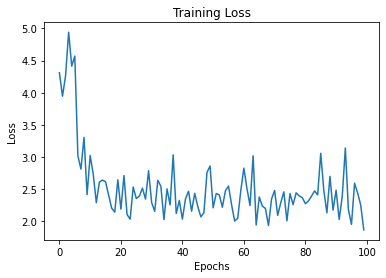

In [16]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_lst)
plt.show()

In [17]:
# for i in tqdm(range(numEpochs)):
#   for X, y in train_loader:

#     X = torch.squeeze(X).cuda()
#     y = y.T.cuda()

#     y_hat = model(X)

#     optimizer.zero_grad() 
#     y_hat = model(X)
#     y_log = torch.log(y+1)
#     loss = loss_function(y_hat, y_log) #calculate the loss
#     loss.backward() #backprop
#     optimizer.step() #does the update

#   if i % 1 == 0:
#       print ("Epoch: {0}, Loss: {1}, ".format(i, loss.cpu().data.numpy()))

In [18]:
# # init empty model
# modelA = myNeuralNetwork(7)
# optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.01)

# # load checkpoint from saved path
# path = os.path.join("/content",
#                               "drive", 
#                               ".shortcut-targets-by-id", 
#                               "19icV-F9BFrur0fxo4XvAZ82qIhipVrb-",
#                               "aiProjectData50021",
#                               "models",
#                               "model_20210729_1755_10epochs.pt")
# checkpoint = torch.load(path)

# # load model
# modelA.load_state_dict(checkpoint['model_state_dict'])
# optimizerA.load_state_dict(checkpoint['optimizer_state_dict'])

In [19]:
# # torch.cuda.empty_cache()
# if using_GPU:
#   modelA = modelA.cuda()

# # Check if the Module is on GPU by checking if a parameter is on GPU
# print("Model on GPU?:")
# print(next(modelA.parameters()).is_cuda)

## Evaluate the model

In [20]:
test_loader = DataLoader(dataset = TwitterDataset(overallTest, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)
model.eval()
# cumLoss = 0
for (i, (X, y)) in enumerate(test_loader):
  X = torch.squeeze(X).cuda()
  y = y.T.cuda()
  y_hat = model(X)
  y_log = torch.log(y+1)
  # cum_loss += loss_fn(scores, labels).item()
  loss = loss_function(y_hat, y_log)
  # cumLoss += loss

# print(f"MSELoss: {cumLoss / len(test_loader)}")
print(f"MSELoss: {loss}")

MSELoss: 2.2635576725006104


# Save your model

In [21]:
import time
PATH = "model_20210730_{0}.pt".format(time.time()) #change this name to the name of your network

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

# Load model from elsewhere
Just a reminder of how to load the model elsewhere after u save it. Also for me to deploy into the UI after you're done

In [22]:
# # init empty model
# modelA = NeuralNetwork()
# optimModelA = optim.SGD(modelA.parameters(), lr=0.001, momentum=0.9)

# # load checkpoint from saved path
# checkpoint = torch.load(PATH)

# # load model
# modelA.load_state_dict(checkpoint['model_state_dict'])
# optimizerA.load_state_dict(checkpoint['optimizer_state_dict'])

# modelA.eval()
# # - or -
# modelA.train()